In [50]:
import nltk
from nltk.corpus import reuters
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

In [34]:
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('test/')])

In [35]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [39]:
tfidfvectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words = 'english')
tfidf_vectorised_train_documents = tfidfvectorizer.fit_transform(train_documents)
tfidf_vectorised_test_documents = tfidfvectorizer.transform(test_documents)

In [40]:
train_documents[0], tfidf_vectorised_train_documents[0].toarray()

('BAHIA COCOA REVIEW\n  Showers continued throughout the week in\n  the Bahia cocoa zone, alleviating the drought since early\n  January and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  Comissaria Smith said in its weekly review.\n      The dry period means the temporao will be late this year.\n      Arrivals for the week ended February 22 were 155,221 bags\n  of 60 kilos making a cumulative total for the season of 5.93\n  mln against 5.81 at the same stage last year. Again it seems\n  that cocoa delivered earlier on consignment was included in the\n  arrivals figures.\n      Comissaria Smith said there is still some doubt as to how\n  much old crop cocoa is still available as harvesting has\n  practically come to an end. With total Bahia crop estimates\n  around 6.4 mln bags and sales standing at almost 6.2 mln there\n  are a few hundred thousand bags still in the hands of farmers,\n  middlemen, exporters and processors.\n 

In [183]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_categories)
test_labels = mlb.transform(test_categories)
train_labels.shape

(7769, 90)

In [97]:
## 5000 out of 35658 components captured 95% variance
# Takes about 5 mins
from sklearn.decomposition import TruncatedSVD

# instantiate TruncatedSVD
svd = TruncatedSVD(n_components=5000)

svd_train_features = svd.fit_transform(tfidf_vectorised_train_documents)

svd_test_features = svd.transform(tfid_vectorised_test_documents)


In [98]:
svd_train_features.shape, svd.explained_variance_ratio_.sum()


((7769, 5000), 0.9561931737181517)

In [99]:
tfidf_vectorised_train_documents.shape, train_labels.shape

((7769, 35658), torch.Size([7769, 90]))

In [100]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [103]:
train_features = torch.tensor(svd_train_features)
train_labels = torch.tensor(train_labels)

test_features = torch.tensor(svd_test_features)
test_labels = torch.tensor(test_labels)

In [108]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


dataset = TensorDataset(train_features, train_labels)
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [105]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# define the architecture
class MultiLabelNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiLabelNetwork, self).__init__()

        self.layer1 = nn.Linear(input_dim, 2048)
        self.layer2 = nn.Linear(2048, 1024)
        self.layer3 = nn.Linear(1024, 256)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))  # use sigmoid for multilabel
        return x

# instantiate the model
input_dim = 5000
num_classes = 90
model = MultiLabelNetwork(input_dim, num_classes).to(device)

# define a loss function and optimizer
criterion = nn.BCELoss()  # cross-entropy loss for multilabel
optimizer = optim.SGD(model.parameters(), lr=0.005)

num_epochs = 50
train_loss, val_loss = [],[]
running_corrects_train, running_corrects_test = 0,0
# training loop
for epoch in range(1,num_epochs+1):
    # reset the tqdm bar
    #tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for inputs, labels in train_dataloader:  # assuming dataloader is defined
        
        model.train()
        
        batch_features, batch_labels = inputs.to(device), labels.to(device)
        batch_features, batch_labels = batch_features.float(), batch_labels.float()
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        
    train_loss.append(loss.item())
    
    # Get validation loss
    val_loss_running = 0
    for inputs, labels in test_dataloader:
        model.eval()
        batch_features, batch_labels = inputs.to(device), labels.to(device)
        batch_features, batch_labels = batch_features.float(), batch_labels.float()
        outputs = model(batch_features)
        val_loss_running += criterion(outputs, batch_labels).item()
    
    
    val_loss.append(val_loss_running/len(test_dataloader.dataset)*16)
        
    print(f'Epoch {epoch}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss_running/len(test_dataloader.dataset)*16}')
        #tqdm_bar.set_postfix({'loss': loss.item()})

Epoch 1/50, Training Loss: 0.6871690154075623, Validation Loss: 0.6881645979096298
Epoch 2/50, Training Loss: 0.6792840957641602, Validation Loss: 0.6805540889096836
Epoch 3/50, Training Loss: 0.6716938614845276, Validation Loss: 0.6730469801284573
Epoch 4/50, Training Loss: 0.6645868420600891, Validation Loss: 0.6654557442578231
Epoch 5/50, Training Loss: 0.6564551591873169, Validation Loss: 0.6576445346717291
Epoch 6/50, Training Loss: 0.6486063003540039, Validation Loss: 0.6494856310348789
Epoch 7/50, Training Loss: 0.6398376226425171, Validation Loss: 0.640838107828985
Epoch 8/50, Training Loss: 0.6310294270515442, Validation Loss: 0.631506877531473
Epoch 9/50, Training Loss: 0.6207053065299988, Validation Loss: 0.6212517014004687
Epoch 10/50, Training Loss: 0.6086941361427307, Validation Loss: 0.6097621570244732
Epoch 11/50, Training Loss: 0.5972040295600891, Validation Loss: 0.5966190705831653
Epoch 12/50, Training Loss: 0.5801935195922852, Validation Loss: 0.5812465769441446
Epo

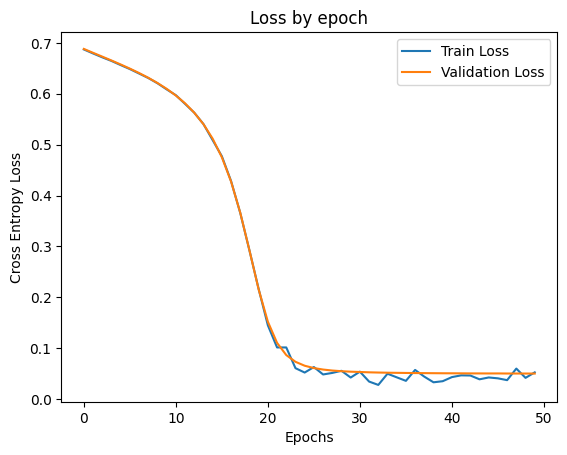

In [154]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0,num_epochs)
plt.plot(x, train_loss, label='Train Loss')
plt.plot(x, val_loss, '-', label='Validation Loss')

plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title('Loss by epoch')

plt.legend()
plt.show()

In [135]:
label_agg =[]
prediction_agg = []

for inputs, labels in test_dataloader:
    model.eval()
    batch_features, batch_labels = inputs.to(device), labels.to(device)
    batch_features, batch_labels = batch_features.float(), batch_labels.float()
    outputs = model(batch_features)
    
    _, preds = torch.max(outputs, 1)
    
    label_agg.append(labels)
    prediction_agg.append(preds)

In [142]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, device):
    model.eval()  # switch to evaluation mode
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = inputs.float(), labels.float()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # get the index of the max log-probability

            true_labels.extend(labels.detach().cpu().numpy())
            predictions.extend(preds.detach().cpu().numpy())
    
    return true_labels, predictions
    #accuracy = accuracy_score(true_labels, predictions)
    #return accuracy

# Use the function:
accuracy = evaluate(model, test_dataloader, device)
# print('Test Accuracy: ', accuracy)

In [17]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

classifier = OneVsRestClassifier(LinearSVC())
classifier.fit(vectorised_train_documents, train_labels)

CPU times: user 1.51 s, sys: 20 ms, total: 1.53 s
Wall time: 1.53 s


OneVsRestClassifier(estimator=LinearSVC())

In [18]:
%%time
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, random_state = 42, shuffle = True)
scores = cross_val_score(classifier, vectorised_train_documents, train_labels, cv = kf)

CPU times: user 12.7 s, sys: 195 ms, total: 12.9 s
Wall time: 12.9 s


In [19]:
print('Cross-validation scores:', scores)
print('Cross-validation accuracy: {:.4f} (+/- {:.4f})'.format(scores.mean(), scores.std() * 2))

Cross-validation scores: [0.83526384 0.86872587 0.80566281 0.83140283 0.83783784 0.81595882
 0.82754183 0.80566281 0.80566281 0.82860825]
Cross-validation accuracy: 0.8262 (+/- 0.0370)


In [170]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

predictions = classifier.predict(tfidf_vectorised_test_documents)

accuracy = accuracy_score(test_labels, predictions)

macro_precision = precision_score(test_labels, predictions, average='macro')
macro_recall = recall_score(test_labels, predictions, average='macro')
macro_f1 = f1_score(test_labels, predictions, average='macro')

micro_precision = precision_score(test_labels, predictions, average='micro')
micro_recall = recall_score(test_labels, predictions, average='micro')
micro_f1 = f1_score(test_labels, predictions, average='micro')

cm = confusion_matrix(test_labels.argmax(axis = 1), predictions.argmax(axis = 1))

print("Accuracy: {:.4f}\nPrecision Macro: {:.4f}\nPrecision Micro: {:.4f}\nRecall Macro: {:.4f}\nRecall Micro: {:.4f}\nF1-measure Macro: {:.4f}\nF1-measure Micro: {:.4f}".format(accuracy, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))

Accuracy: 0.8099
Precision Macro: 0.6074
Precision Micro: 0.9467
Recall Macro: 0.3702
Recall Micro: 0.7970
F1-measure Macro: 0.4405
F1-measure Micro: 0.8654


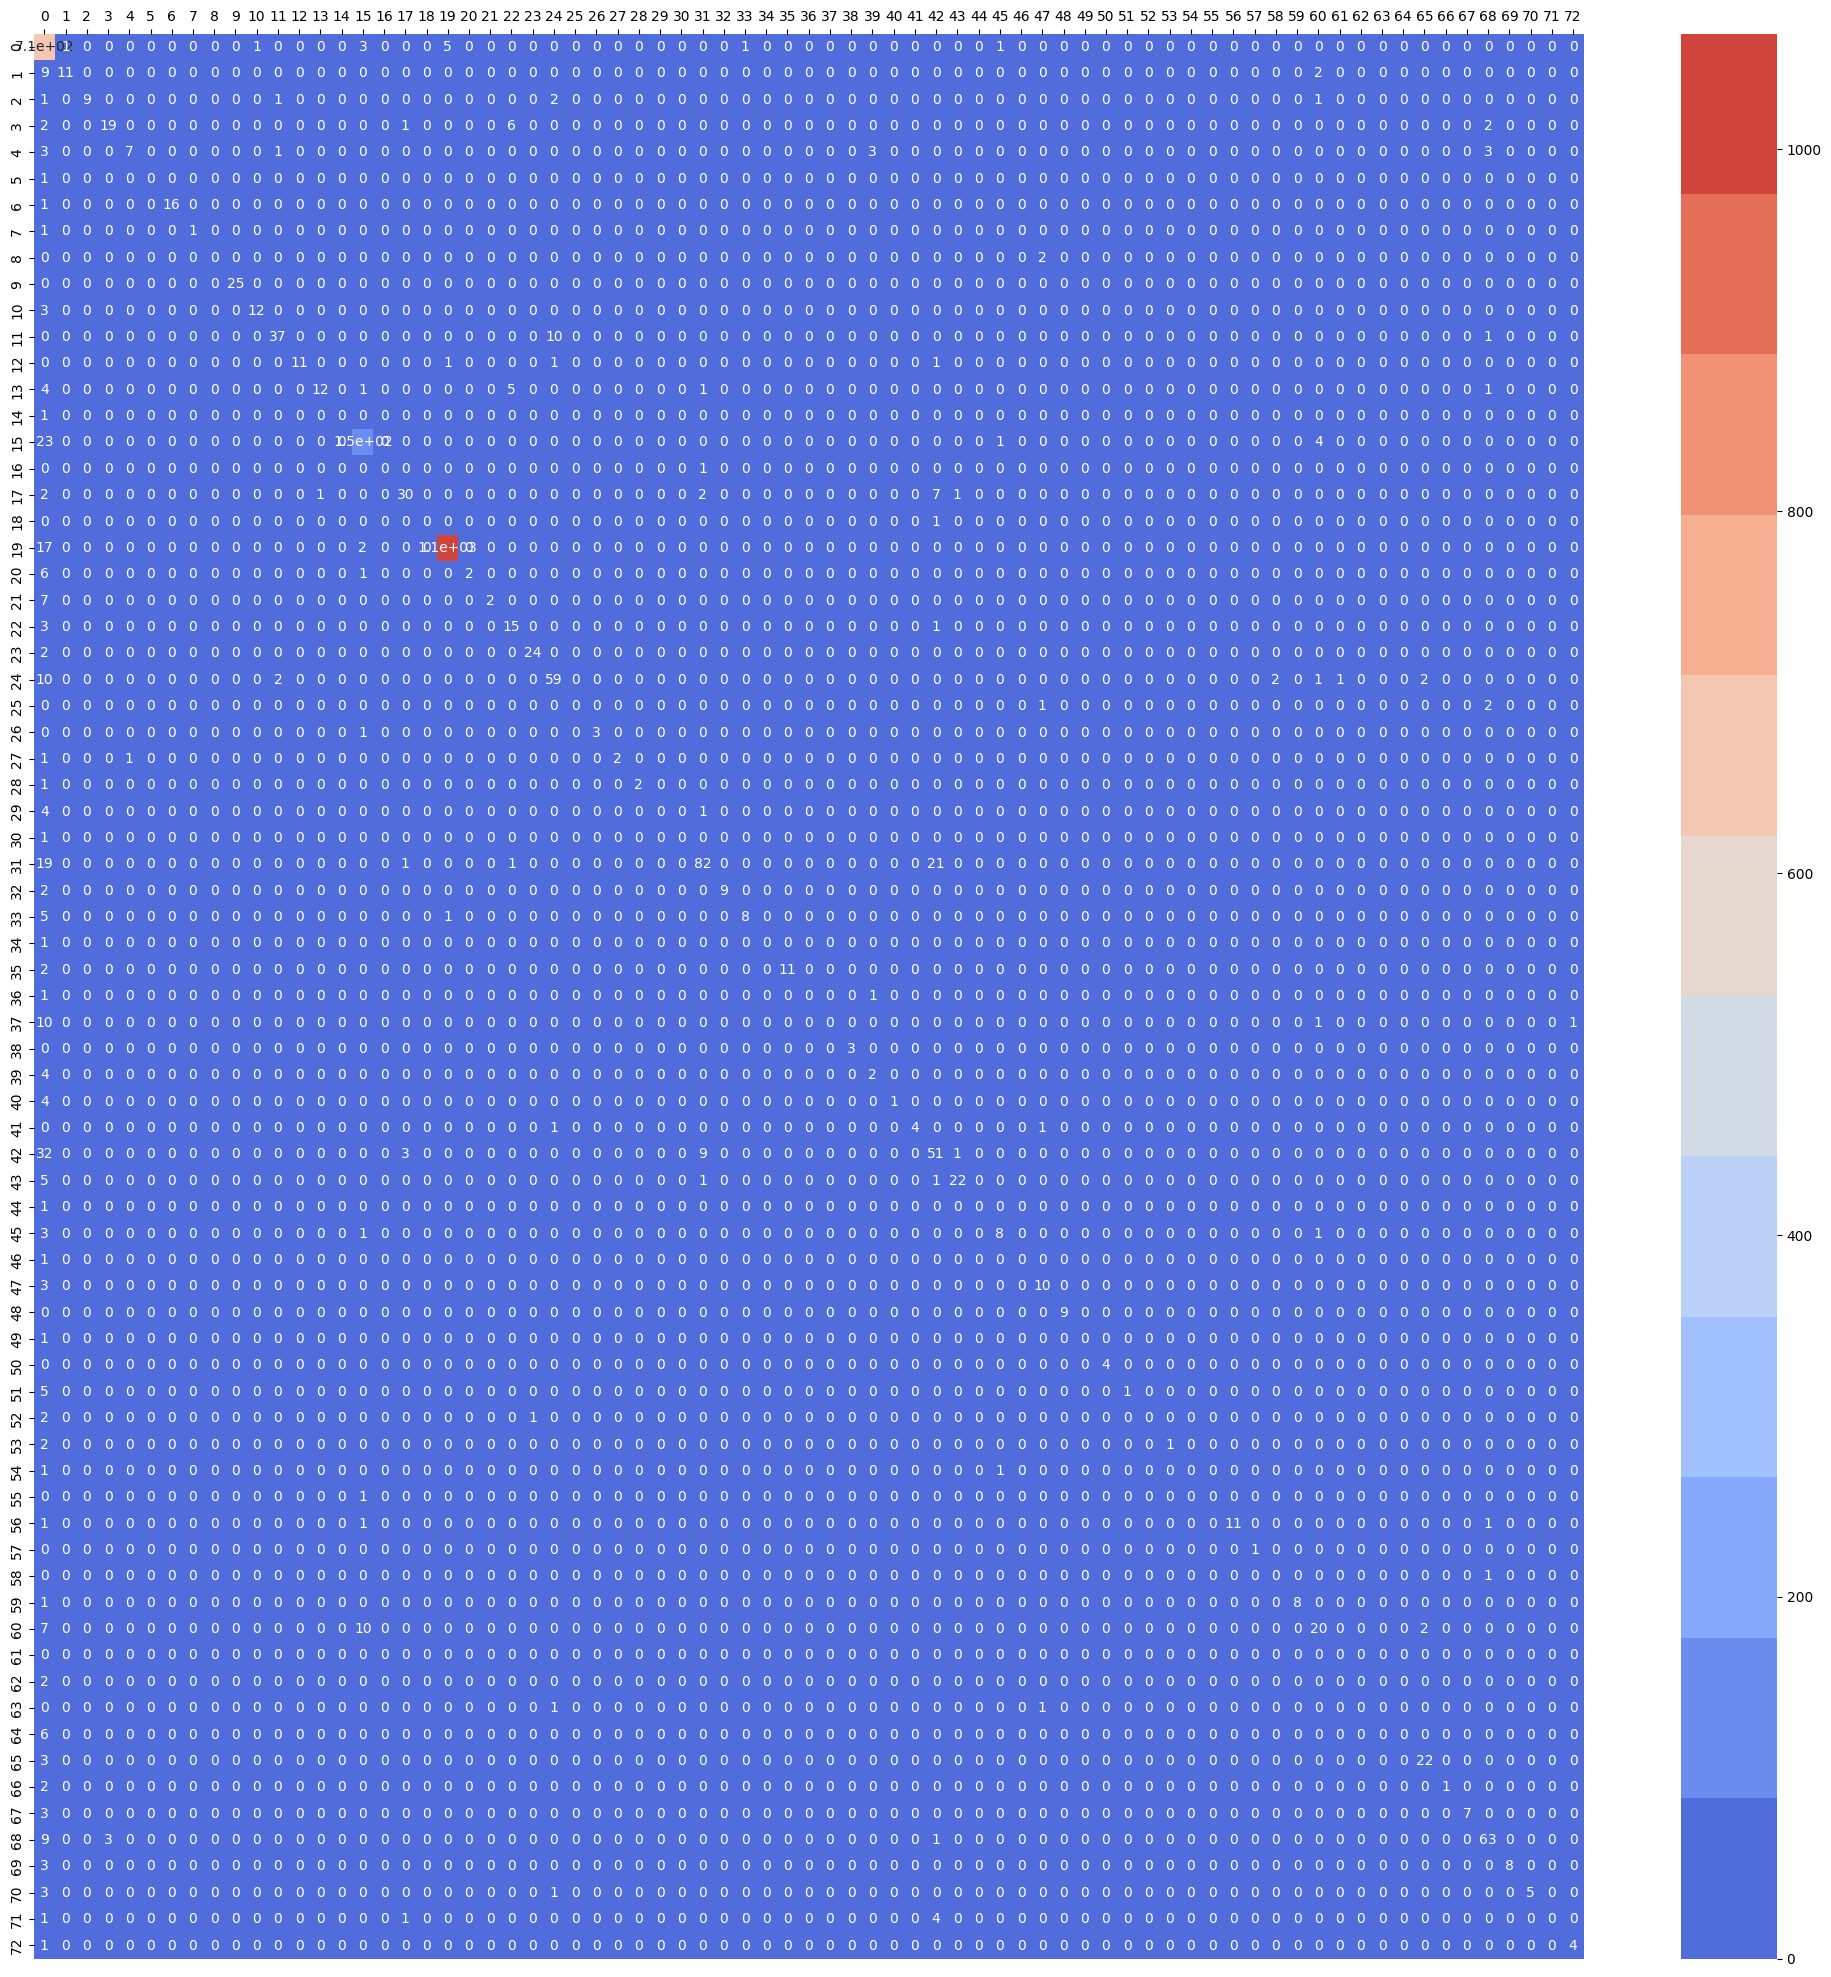

In [163]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

cm_plt = pd.DataFrame(cm[:73])

plt.figure(figsize = (25, 25))
ax = plt.axes()

sb.heatmap(cm_plt, annot=True, cmap=sb.color_palette("coolwarm",12))

ax.xaxis.set_ticks_position('top')

plt.show()

In [192]:
index=98

print(train_documents[index])

tfidf_vectorised_train_documents = tfidfvectorizer.fit_transform(train_documents)
predictions = classifier.predict(tfidf_vectorised_train_documents)

mlb.inverse_transform(np.array([predictions[index]]))

N.Y. BANK DISCOUNT BORROWINGS NIL IN WEEK
  The eight major New York City banks
  did not borrow from the Federal Reserve in the week ended
  Wednesday March 25, a Fed spokesman said.
      It was the second half of a two-week bank statement period
  that ended on Wednesday. The banks did not borrow in the first
  week of the period.
  




[('interest', 'money-supply')]

In [174]:
print(predictions[index])

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [175]:
y_inverse = mlb.inverse_transform(predictions[index])
print(y_inverse)

IndexError: tuple index out of range

In [189]:
np.array([predictions[index]])

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [185]:
mlb.inverse_transform(train_labels)

[('cocoa',),
 ('acq',),
 ('money-supply',),
 ('acq',),
 ('earn',),
 ('earn',),
 ('acq', 'trade'),
 ('earn',),
 ('crude', 'nat-gas'),
 ('cocoa', 'coffee', 'sugar'),
 ('veg-oil',),
 ('acq',),
 ('earn',),
 ('acq',),
 ('earn',),
 ('earn',),
 ('earn',),
 ('earn',),
 ('earn',),
 ('gas',),
 ('earn',),
 ('earn',),
 ('acq',),
 ('iron-steel', 'ship'),
 ('earn',),
 ('money-fx',),
 ('acq',),
 ('earn',),
 ('acq',),
 ('earn',),
 ('earn',),
 ('earn',),
 ('acq',),
 ('earn',),
 ('cotton',),
 ('earn',),
 ('acq',),
 ('acq',),
 ('earn',),
 ('earn',),
 ('earn',),
 ('acq',),
 ('acq', 'earn'),
 ('earn',),
 ('dlr', 'money-fx'),
 ('earn',),
 ('acq', 'crude'),
 ('money-supply',),
 ('interest', 'money-fx'),
 ('crude',),
 ('dlr', 'money-fx'),
 ('earn',),
 ('earn',),
 ('acq',),
 ('acq',),
 ('earn',),
 ('earn',),
 ('earn',),
 ('interest', 'money-fx'),
 ('earn',),
 ('earn',),
 ('earn',),
 ('earn',),
 ('earn',),
 ('acq',),
 ('earn',),
 ('money-supply',),
 ('earn',),
 ('coffee',),
 ('acq',),
 ('earn',),
 ('acq', 'crud

[('cocoa',)]